In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import tqdm
import matplotlib.pyplot as plt

from copy import deepcopy
from torch.utils.data import Dataset, DataLoader

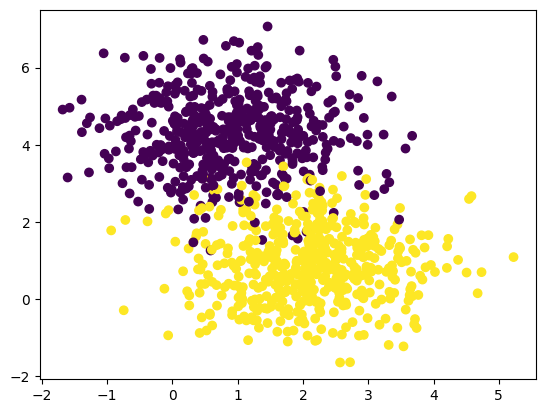

In [11]:
# make 2 blobs of data using sklearn
from sklearn.datasets import make_blobs

data = make_blobs(n_samples=1000, n_features=2, centers=2, cluster_std=1.0, random_state=0)

plt.scatter(data[0][:,0], data[0][:,1], c=data[1])
plt.show()

In [12]:
X = data[0]
y = data[1]

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
print(X_train.shape, y_train.shape, 
    X_val.shape, y_val.shape,
    X_test.shape, y_test.shape)

(720, 2) (720,) (80, 2) (80,) (200, 2) (200,)


In [14]:
class DataTrain(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
class DataTest(Dataset):
    def __init__(self, X):
        self.X = torch.from_numpy(X).float()
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx]

In [15]:
# set batch size to 10, meaning that every 10 samples will be grouped together as a batch for processing
batch_size = 10

# create train and test data classes
train_data = DataTrain(X_train, y_train)
val_data = DataTrain(X_val, y_val)
test_data = DataTrain(X_test, y_test)
#test_data = data_inference(X_test)

# instantiate data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# print out the shapes of the data
print(len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset))

720 80 200


In [16]:
# build neural network class
class NeuralNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 10)
        self.output = nn.Linear(10, output_dim)

    def forward(self, x):
        # define forward pass of data through the network including activation functions
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.output(x))
        return x

In [23]:
def train(model, train_loader, optimizer, objective, device):
    model.train()
    train_batch_loss = []
    train_batch_acc = []

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        n = y.size(0)
        optimizer.zero_grad()
        y_hat = model(x)
        label = y_hat.argmax(dim=1)
        loss = objective(y_hat, y)
        loss.backward()
        optimizer.step()
        train_batch_loss.append(loss.item())
        train_batch_acc.append((label == y).sum().item() / n)

    train_loss = sum(train_batch_loss) / len(train_batch_loss)
    train_acc = sum(train_batch_acc) / len(train_batch_acc)

    return train_loss, train_acc


def validate(model, val_loader, objective, device):
    model.eval()
    val_batch_loss = []
    val_batch_acc = []

    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            n = y_val.size(0)
            y_hat_val = model(x_val)
            label = y_hat_val.argmax(dim=1)
            loss_val = objective(y_hat_val, y_val)
            val_batch_loss.append(loss_val.item())
            val_batch_acc.append((label == y_val).sum().item() / n)

    val_loss = sum(val_batch_loss) / len(val_batch_loss)
    val_acc = sum(val_batch_acc) / len(val_batch_acc)

    return val_loss, val_acc

def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    accuracy = []
    with torch.no_grad():
        for x_test, y_test in data_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            y_hat = model(x_test)
            label = y_hat.argmax(dim=1)
            predictions.append(label)
            accuracy.append((label == y_test).sum().item() / len(y_test))
    accuracy = sum(accuracy) / len(accuracy)
    return predictions, accuracy

def predict(model, data_loader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for x in data_loader:
            x = x.to(device)
            n = x.size(0)
            y_hat = model(x)
            label = y_hat.argmax(dim=1)
            predictions.append(label)

    return predictions

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_validation_loss = float('inf')
        self.best_model_weights = None

    def early_stop(self, validation_loss, model):
        print(f"Early Stopping counter: {self.counter} out of {self.patience}")
        if validation_loss < self.best_validation_loss - self.min_delta:
            self.best_validation_loss = validation_loss
            self.counter = 1
            self.save_best_weights(model)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def save_best_weights(self, model):
        self.best_model_weights = deepcopy(model.state_dict())

    def restore_best_weights(self, model):
        model.load_state_dict(self.best_model_weights)

In [25]:
# lists to store loss and accuracy
train_loss = []
val_loss = []
train_acc = []
val_acc = []

# training lists and parameters
n_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# instantiate model, loss function and optimizer
model = NeuralNet(X_train.shape[1], 2).to(device)
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=0.01)
early_stopper = EarlyStopper(patience=5, min_delta=0.001)

for epoch in range(n_epochs):
    tr_loss, tr_acc = train(model, train_loader, optimizer, objective, device)
    train_loss.append(tr_loss)
    train_acc.append(tr_acc)

    eva_loss, eva_acc = validate(model, val_loader, objective, device)
    val_loss.append(eva_loss)
    val_acc.append(eva_acc)
    print(f'[{epoch+1}/{n_epochs}] Train loss: {tr_loss:.4f} acc: {tr_acc*100:.2f}% - Val loss: {eva_loss:.4f} acc: {eva_acc*100:.2f}%')
    if early_stopper.early_stop(eva_loss, model):
        early_stopper.save_best_weights(model)
        print("Patience Depleated: Early Stopping triggered.")
        break


[1/100] Train loss: 0.4064 acc: 92.22% - Val loss: 0.3811 acc: 95.00%
Early Stopping counter: 0 out of 5
[2/100] Train loss: 0.3931 acc: 93.61% - Val loss: 0.3786 acc: 95.00%
Early Stopping counter: 1 out of 5
[3/100] Train loss: 0.3892 acc: 93.47% - Val loss: 0.3766 acc: 95.00%
Early Stopping counter: 1 out of 5
[4/100] Train loss: 0.3889 acc: 93.61% - Val loss: 0.3781 acc: 97.50%
Early Stopping counter: 1 out of 5
[5/100] Train loss: 0.3903 acc: 93.47% - Val loss: 0.3810 acc: 95.00%
Early Stopping counter: 2 out of 5
[6/100] Train loss: 0.3891 acc: 93.19% - Val loss: 0.3938 acc: 93.75%
Early Stopping counter: 3 out of 5
[7/100] Train loss: 0.3864 acc: 93.75% - Val loss: 0.3771 acc: 97.50%
Early Stopping counter: 4 out of 5
Patience Depleated: Early Stopping triggered.
